In [57]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error


# 3.1

In [5]:
# 3.1 Read data

data = pd.read_csv('../ToyotaCorolla.csv')

print(data.head(10))

df = data.copy()


In [28]:
# 3.1 inspects columns and convert object to category

print(df.columns)
print(df.dtypes)

object_cols = df.select_dtypes('object').columns
for col in object_cols:
    df[col] = df[col].astype('category')

df['Mfg_Year'] = df['Mfg_Year'].astype('category')

Index(['Id', 'Model', 'Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM',
       'Fuel_Type', 'HP', 'Met_Color', 'Color', 'Automatic', 'CC', 'Doors',
       'Cylinders', 'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee',
       'BOVAG_Guarantee', 'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2',
       'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player',
       'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio',
       'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
       'Radio_cassette', 'Parking_Assistant', 'Tow_Bar'],
      dtype='object')
Id                      int64
Model                category
Price                   int64
Age_08_04               int64
Mfg_Month               int64
Mfg_Year                int64
KM                      int64
Fuel_Type            category
HP                      int64
Met_Color               int64
Color                category
Automatic               int64
CC                      int64
Doors                   

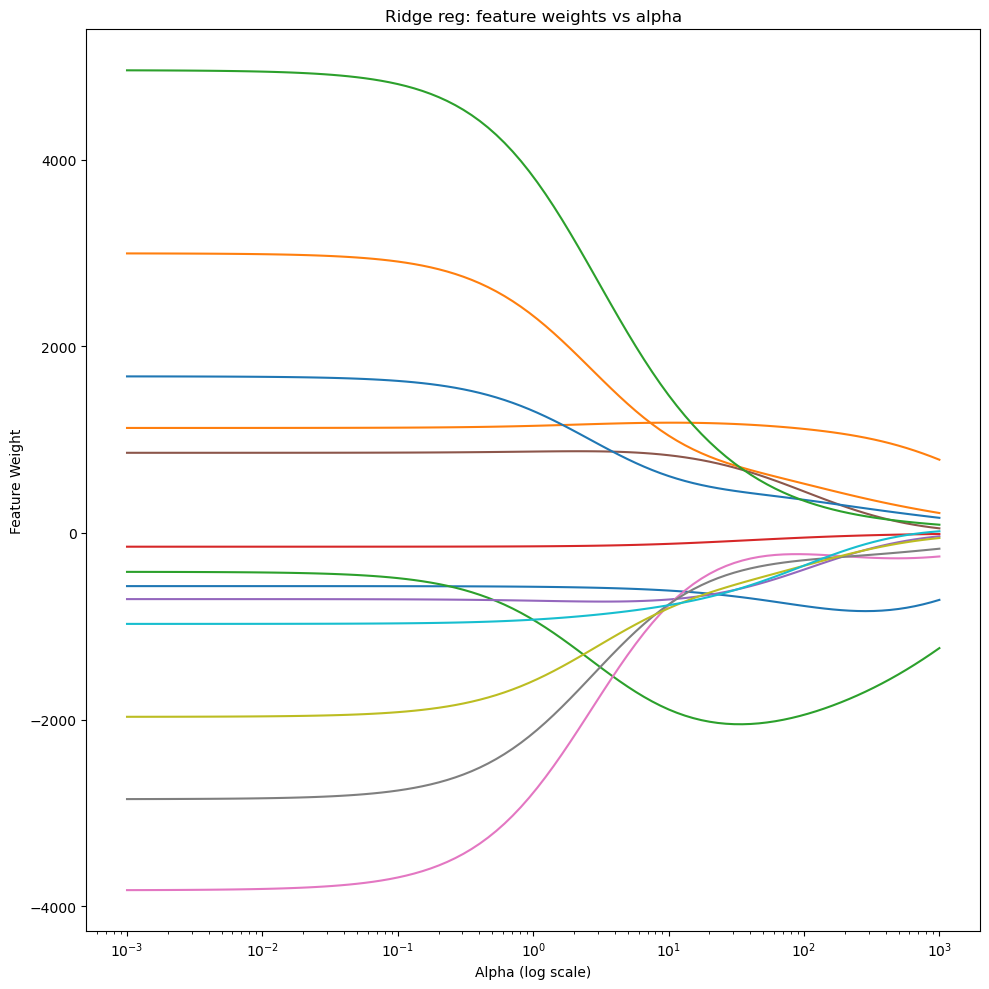

In [29]:
# 3.1 Make design matrix and target vector, and split


X = df[['KM', 'Weight', 'Age_08_04', 'Fuel_Type', 'Mfg_Year']]
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.2)

numerical_cols = X.select_dtypes('int64').columns
categorical_cols = X.select_dtypes('category').columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(), categorical_cols)
])

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

alphas = np.logspace(-3, 3, 100)
coefficients = []

for alpha in alphas:
    ridge_pipeline.set_params(ridge__alpha=alpha)
    ridge_pipeline.fit(X_train, y_train)
    coefficients.append(ridge_pipeline.named_steps['ridge'].coef_)

coefficients = np.array(coefficients)

plt.figure(figsize=(10,10))
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:,i])

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Feature Weight')
plt.title('Ridge reg: feature weights vs alpha')
plt.tight_layout()
plt.show()

##### From the plot above, we can learn that most features shrink in weight size with increasing alpha, some of them to 0, as expected.

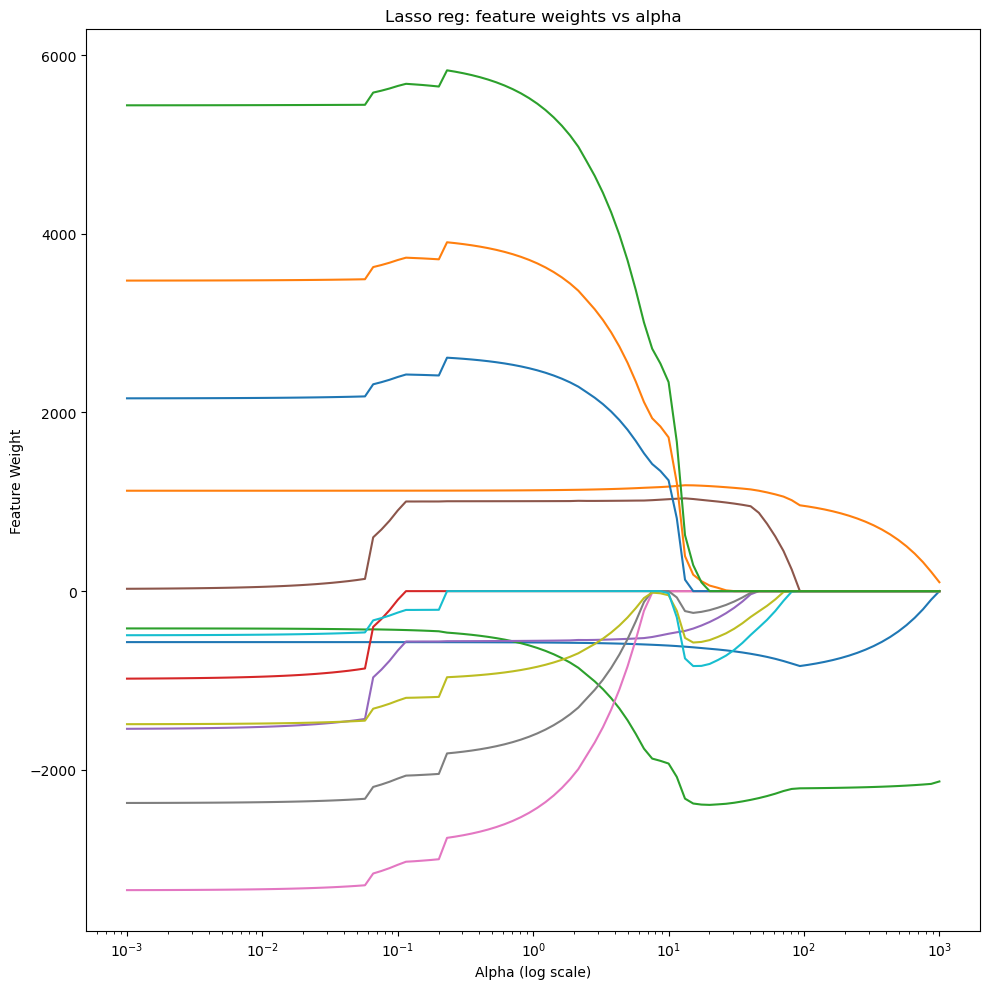

In [30]:
# 3.1 Make the same plot for Lasso

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso())
])

alphas = np.logspace(-3, 3, 100)
coefficients = []

for alpha in alphas:
    lasso_pipeline.set_params(lasso__alpha=alpha)
    lasso_pipeline.fit(X_train, y_train)
    coefficients.append(lasso_pipeline.named_steps['lasso'].coef_)

coefficients = np.array(coefficients)

plt.figure(figsize=(10,10))
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:,i])

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Feature Weight')
plt.title('Lasso reg: feature weights vs alpha')
plt.tight_layout()
plt.show()

##### Even faster more 0 coefficients.

In [34]:
# 3.1 Cumbersome way to get the feature names of important variables

ohe_feature_names = lasso_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)

# Combine numerical and one-hot encoded categorical feature names
all_feature_names = np.concatenate([numerical_cols, ohe_feature_names])

coef_df = pd.DataFrame(coefficients, columns=all_feature_names)
print(coef_df.iloc[99,:])

#age and weight are most important.

KM                    -0.000000
Weight                99.775208
Age_08_04          -2130.609336
Fuel_Type_CNG         -0.000000
Fuel_Type_Diesel      -0.000000
Fuel_Type_Petrol       0.000000
Mfg_Year_1998         -0.000000
Mfg_Year_1999         -0.000000
Mfg_Year_2000         -0.000000
Mfg_Year_2001         -0.000000
Mfg_Year_2002          0.000000
Mfg_Year_2003          0.000000
Mfg_Year_2004          0.000000
Name: 99, dtype: float64


In [ ]:
# not even going to try without scaling.

In [59]:
# 3.1 Doing lasso cv including all variables

df = data.copy()
for col in df.columns:
    if df[col].nunique() < 20:
        df[col] = df[col].astype('category')

df = df.drop(columns=['Id', 'Model'])

X = df.drop(columns=['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size= 0.2, shuffle=True, random_state=42)

categorical_cols = X_train.select_dtypes('category').columns
numerical_cols = X_train.select_dtypes('int64').columns
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

lassoCV_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lassoCV', LassoCV(alphas = np.logspace(-4,4,100), random_state=42 , cv =5))
])

lassoCV_pipeline.fit(X_train, y_train)

mse_path = lassoCV_pipeline.named_steps['lassoCV'].mse_path_
alphas = lassoCV_pipeline.named_steps['lassoCV'].alphas_

lasso_results = pd.DataFrame(mse_path, index = alphas)


In [60]:
lasso_results_means = lasso_results.mean(axis = 1)
print(lasso_results_means)

best_alpha = lasso_results_means.idxmin()

preds1 = lassoCV_pipeline.predict(X_test)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train, y_train)
preds2 = lasso.predict(X_test)

mape1 = mean_absolute_percentage_error(y_test, preds1)
mape2 = mean_absolute_percentage_error(y_test, preds2)



10000.000000    1.315242e+07
8302.175681     1.315242e+07
6892.612104     1.315242e+07
5722.367659     1.315242e+07
4750.810162     1.315242e+07
                    ...     
0.000210        1.182798e+06
0.000175        1.182800e+06
0.000145        1.182802e+06
0.000120        1.182804e+06
0.000100        1.182806e+06
Length: 100, dtype: float64


In [61]:
print(mape1)
print(mape2)

0.07451944460905269
0.07451944460905269
